In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [43]:
def sigmoid(hypothesis):
    return 1/(1+ np.exp(-hypothesis))

def getAccuracy(predictions,labels):
    pred_class = np.argmax(predictions, axis=1)
    real_class = np.argmax(labels, axis=1)
    valid_pred = [pred_class == real_class]
    return np.sum(valid_pred)/len(real_class)

def plot_part_1(w1,loss_history,test_loss,train_acc_history,val_acc_history):
    plt.figure(figsize=(7,7))
    plt.plot(loss_history/np.max(loss_history), linewidth=3, label = 'Train Loss')
    plt.plot(test_loss/np.max(test_loss), linewidth=3, label = 'Test Loss')
    plt.plot(train_acc_history, linewidth=3, label = "Training Accuracy")
    plt.plot(val_acc_history,  linewidth=3, label =  "Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy and Normalized Loss')
    plt.legend(loc='lower right')    

    weights = w1[1:,]# Removing the rows of bias terms.
    weights_pos =  weights- np.min(weights)# Making the minimum weight zero.
    images = ((weights_pos/np.max(weights_pos))*255).astype('uint8')
    CIFAR10 = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    fig, axes  = plt.subplots(2,5, sharex='all', sharey='all', figsize=(25,10))
    location = 1 # Location of the image in the grid of 2x5
    for i in range(K):
        image = images[:,i].reshape(32,32,3)
        plt.subplot(2,5,location),plt.imshow(image[:,:,::-1])
        plt.title("Class: {}".format(CIFAR10[i])),plt.xticks([]),plt.yticks([])    
        location+=1

def plot(w1,w2,loss_history,test_loss,train_acc_history,val_acc_history):
    plt.figure(figsize=(7,7))
    plt.plot(loss_history/np.max(loss_history), linewidth=3, label = 'Train Loss')
    plt.plot(test_loss/np.max(test_loss), linewidth=3, label = 'Test Loss')
    plt.plot(train_acc_history, linewidth=3, label = "Training Accuracy")
    plt.plot(val_acc_history,  linewidth=3, label =  "Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy and Normalized Loss')
    plt.legend(loc='lower right')    

    weights = w1[1:,].dot(w2[1:,]) # Removing the rows of bias terms.
    weights_pos =  weights- np.min(weights)# Making the minimum weight zero.
    images = ((weights_pos/np.max(weights_pos))*255).astype('uint8')
    CIFAR10 = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    fig, axes  = plt.subplots(2,5, sharex='all', sharey='all', figsize=(25,10))
    location = 1 # Location of the image in the grid of 2x5
    for i in range(K):
        image = images[:,i].reshape(32,32,3)
        plt.subplot(2,5,location),plt.imshow(image[:,:,::-1])
        plt.title("Class: {}".format(CIFAR10[i])),plt.xticks([]),plt.yticks([])    
        location+=1

In [39]:
# Loading the Data Set
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape); print('y_train: ', y_train.shape)

print("Pre-processing loaded data...\n")
# y_train contains labels form 0 to 9 corresponding to 10 classes.
K = len(np.unique(y_train)) # Number of Classes

Ntr = x_train.shape[0]; print('Number of training samples:', Ntr) # Number of training samples 50,000
Nte = x_test.shape[0];  print('Number of test samples: ',Nte,'\n')# Number of test samples 10,000
Din = 3072 # CIFAR10 # 32x32x3 = height x width x channel

# Normalize pixel values: Image data preprocessing
x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0) # axis=0: mean of a column; Mean of each pixel
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K); print('y_train: ', y_train.shape); #print(y_train[0:10,:])
y_test =  tf.keras.utils.to_categorical(y_test,  num_classes=K);

x_train = np.reshape(x_train,(Ntr,Din)).astype('float32')
x_test = np.reshape(x_test,(Nte,Din)).astype('float32')
print('x_train: ', x_train.shape)
print('x_test: ', x_test.shape)

x_train:  (50000, 32, 32, 3)
y_train:  (50000, 1)
Pre-processing loaded data...

Number of training samples: 50000
Number of test samples:  10000 

y_train:  (50000, 10)
x_train:  (50000, 3072)
x_test:  (10000, 3072)


In [40]:
print("Initializing the weight matrix with random weights...")
std=1e-5 # For random samples from N(\mu, \sigma^2), use: sigma * np.random.randn(...) + mu
w1 = std*np.random.randn(Din, K) # Initializing the weight matrix with random weights
b1 = np.zeros(K) # Initializing the bias vector
print("w1:", w1.shape);print("b1:", b1.shape)


print("Rearranging train and test samples...")

# Rearranging train and test samples: (ra=rearranged)
x_train_ra = np.concatenate((np.ones((x_train.shape[0],1)),x_train), axis=1); print('Rearranged x_train: ', x_train_ra.shape)
x_test_ra  = np.concatenate((np.ones((x_test.shape[0],1)),x_test), axis=1)

# Rearranging weight matrix and bias matrix into single matrix
w1 = np.concatenate((b1.reshape(1,K), w1), axis=0); print('Rearranged w1: ',w1.shape)

print("Rearranging completed.\n")

#------------------------------------------------------------------------------------------

iterations = 300  # Gradient descent interations
lr = 1.4e-2 # Learninig rate
lr_decay= 0.999
reg = 5e-6

loss_history = [] # Vlaues of loss function at each iteration 
test_loss = []
train_acc_history = [] # Training accuracy
val_acc_history = [] # Validation accuracy


m = x_train.shape[0]  # Number of training examples
m2 = x_test_ra.shape[0]

# Running gradient descent number of times speciied in iterations
print("Running gradient descent...")

for t in range(1,iterations+1):    
    # Forward Propagation
    hypothesis = x_train_ra.dot(w1)
    loss = (1/(2*m))*np.sum(( hypothesis - y_train)**2) + (1/(2*m))*reg*np.sum(w1**2) 
    loss_history.append(loss)
    
    # Backward Propagation
    dw1 = (1/m)*(x_train_ra.T.dot(hypothesis - y_train))  + (1/m)*reg*w1 
    w1 = w1 - lr*dw1
    
    
    # Training Accuracy and Validation Accuracy
    train_acc = getAccuracy(hypothesis, y_train)
    train_acc_history.append(train_acc)
    valid_acc = getAccuracy(x_test_ra.dot(w1), y_test)
    val_acc_history.append(valid_acc)
   
    # Test Loss    
    t_loss = (1/(2*m2))*np.sum(( x_test_ra.dot(w1) - y_test)**2) + (1/(2*m2))*reg*np.sum(w1**2) 
    test_loss.append(t_loss)
    
    # Print details for selected iterations
    if (t%50==0) or (t==1):
        print("| Epoch {:03} | Loss {:.4f} | accuracy: {:.4f} | val_loss: {:.4f} | val_accuracy: {:.4f} |"\
             .format(t, loss, train_acc, t_loss, valid_acc))
    
    
    # Decaying learning rate
    lr = lr*lr_decay
    
print("Gradient Descent completed. Parameters were trained")

Initializing the weight matrix with random weights...
w1: (3072, 10)
b1: (10,)
Rearranging train and test samples...
Rearranged x_train:  (50000, 3073)
Rearranged w1:  (3073, 10)
Rearranging completed.

Running gradient descent...
| Epoch 001 | Loss 0.5000 | accuracy: 0.1085 | val_loss: 0.4845 | val_accuracy: 0.2493 |
| Epoch 050 | Loss 0.4168 | accuracy: 0.3765 | val_loss: 0.4163 | val_accuracy: 0.3778 |
| Epoch 100 | Loss 0.4033 | accuracy: 0.3918 | val_loss: 0.4034 | val_accuracy: 0.3900 |
| Epoch 150 | Loss 0.3987 | accuracy: 0.3994 | val_loss: 0.3992 | val_accuracy: 0.3939 |
| Epoch 200 | Loss 0.3967 | accuracy: 0.4040 | val_loss: 0.3974 | val_accuracy: 0.3962 |
| Epoch 250 | Loss 0.3954 | accuracy: 0.4072 | val_loss: 0.3964 | val_accuracy: 0.3959 |
| Epoch 300 | Loss 0.3946 | accuracy: 0.4102 | val_loss: 0.3958 | val_accuracy: 0.3984 |
Gradient Descent completed. Parameters were trained


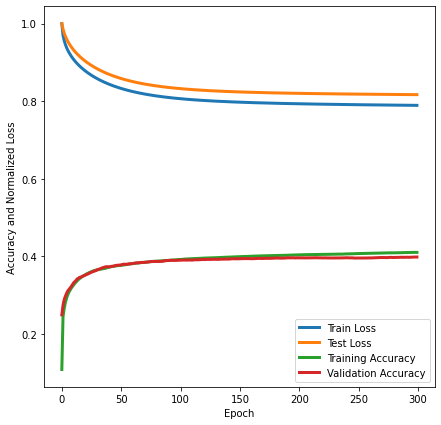

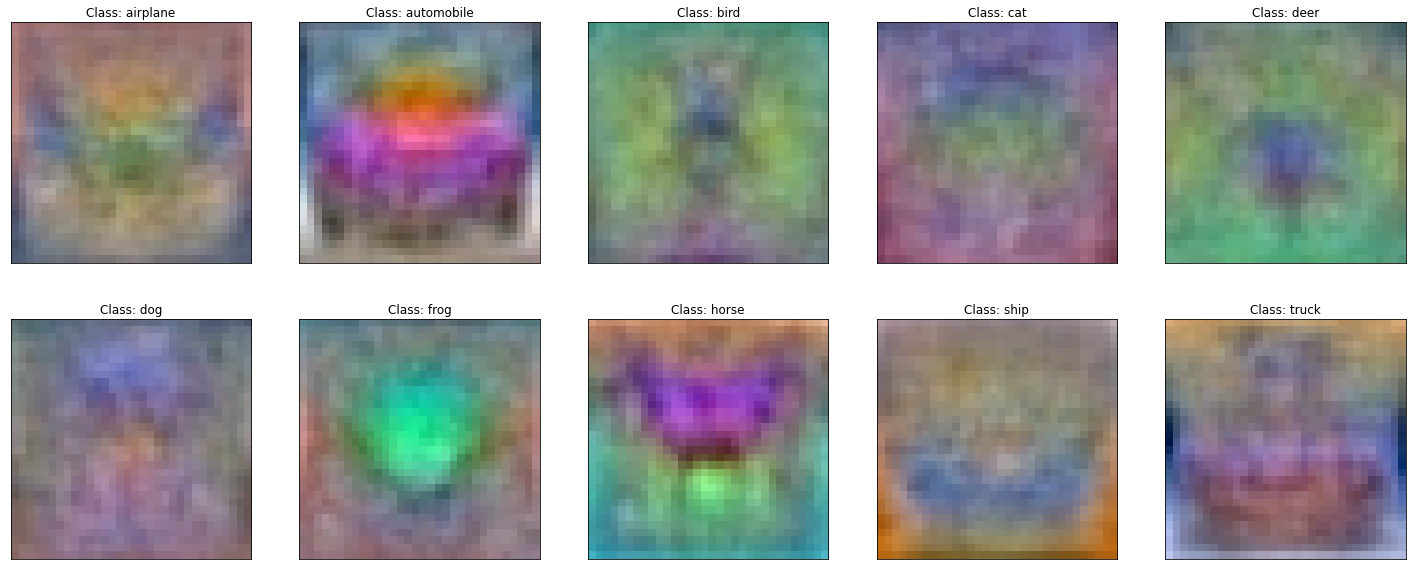

In [44]:
plot_part_1(w1,loss_history,test_loss,train_acc_history,val_acc_history)

Part 2


In [9]:
# Loading the Data Set
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape); print('y_train: ', y_train.shape)
#print(y_train[0:10])

print("Pre-processing loaded data...\n")
# y_train contains labels form 0 to 9 corresponding to 10 classes.
K = len(np.unique(y_train)) # Number of Classes

Ntr = x_train.shape[0]; print('Number of training samples:', Ntr) # Number of training samples 50,000
Nte = x_test.shape[0]; print('Number of test samples: ',Nte,'\n')      # Number of test samples 10,000
Din = 3072 # CIFAR10 # 32x32x3 = height x width x channel

# Image data preprocessing
"""
Remove the normalization. Otherwise the model will not learn.
Because when the weights are extrememly small,
weight matrix will consist of almost the same elements.
and learning will stop.
"""
#x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0) # axis=0: mean of a column; Mean of each pixel
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K); print('y_train: ', y_train.shape); #print(y_train[0:10,:])
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K); #print(y_test[0:10,:])

x_train = np.reshape(x_train,(Ntr,Din)).astype('float32');# print(x_train[0:10, 0:20])
x_test = np.reshape(x_test,(Nte,Din)).astype('float32')
print('x_train: ', x_train.shape)
print('x_test: ', x_test.shape)

x_train:  (50000, 32, 32, 3)
y_train:  (50000, 1)
Pre-processing loaded data...

Number of training samples: 50000
Number of test samples:  10000 

y_train:  (50000, 10)
Reshaped x_train:  (50000, 3072)
Reshaped x_test:  (10000, 3072)
Pre-processing completed.


In [10]:
H = 200 
std=1e-5

# Hidden Layer 
w1 = std*np.random.randn(Din, H) # Initializing the weight matrix with random weights
b1 = np.zeros(H) # Initializing the bias vector
print("w1:", w1.shape)
print("b1:", b1.shape)

# Last Layer
w2 = std*np.random.randn(H, K) # Initializing the weight matrix with random weights
b2 = np.zeros(K) # Initializing the bias vector
print("w2:", w2.shape)
print("b2:", b2.shape)

print("Rearranging train and test samples...")
# Rearranging train and test samples: (ra=rearranged)
x_train_ra = np.concatenate((np.ones((x_train.shape[0],1)),x_train), axis=1); print('Rearranged x_train: ', x_train_ra.shape)
x_test_ra  = np.concatenate((np.ones((x_test.shape[0],1)),x_test), axis=1)

# Rearranging weight matrices and bias vectors into single matrices
w1 = np.concatenate((b1.reshape(1,H), w1), axis=0); print('Rearranged w1: ',w1.shape)
w2 = np.concatenate((b2.reshape(1,K), w2), axis=0); print('Rearranged w2: ',w2.shape)

print("Rearranging completed.")

iterations = 300  # Gradient descent interations
lr = 1.4e-2 # Learninig rate
lr_decay= 0.999
reg = 5e-6
test_loss = []
loss_history = [] # Vlaues of cost function at each iteration 
train_acc_history = []
val_acc_history = []

m = x_train.shape[0]  # Number of training examples
m2 = x_test_ra.shape[0]
# Running gradient descent number of times speciied in iterations
print("Running gradient descent...")

for t in range(1,iterations+1):
    # Forward Propagation
    hypo = sigmoid(x_train_ra.dot(w1)) # Layer 1 with sigmoid activation
    hypothesis = np.concatenate((np.ones((hypo.shape[0],1)),hypo), axis=1) # Rearranging for layer 2
    predict = hypothesis.dot(w2) # Layer 2 
    
    loss = (1/(2*m))*np.sum(( predict - y_train)**2)\
         + (1/(2*m))*reg*np.sum(w1**2) + (1/(2*m))*reg*np.sum(w2**2)
    loss_history.append(loss)
    
    # Back Propagation partial dertivatives of Loss function
    # (dl/dw2) = (dl/dpredict)(dpredic/dw2)
    dpredict =  (1/m)*(predict - y_train)
    dw2 = hypothesis.T.dot(dpredict) + (1/m)*reg*w2
    
    # (dl/dw1) = (dl/dh)(dh/dw1)
    # (dl/dw1) = (dl/dpredict)(dpredic/dh) * (dh/dw1x)(dw1x/dw1)
    dh = dpredict.dot(w2[1:,].T) # Removing bias vector w2(201x10)--> 200x10
    dhdxw1 = hypo*(1 - hypo) #using hypothesis 50000*200 before rearranging.
    dw1 = x_train_ra.T.dot(dh*dhdxw1) + (1/m)*reg*w1
    
    # Gradient Descent
    w1 = w1 - lr*dw1
    w2 = w2 - lr*dw2
    
    # Training Accuracy 
    train_acc = getAccuracy(predict, y_train)
    train_acc_history.append(train_acc)
    
    # Validation Accuracy
    test_hypo = sigmoid(x_test_ra.dot(w1))
    test_hypothesis = np.concatenate((np.ones((test_hypo.shape[0],1)),test_hypo), axis=1)# Rearranging for layer 2
    test_predict = test_hypothesis.dot(w2)
    valid_acc = getAccuracy(test_predict, y_test)
    val_acc_history.append(valid_acc)
    
    # Test Loss    
    t_loss = (1/(2*m2))*np.sum(( test_predict- y_test)**2)\
         + (1/(2*m2))*reg*np.sum(w1**2) + (1/(2*m2))*reg*np.sum(w2**2)
    test_loss.append(t_loss)
    
    # Print details for selected iterations
    if (t%30==0) or (t==1):
        print("| Epoch {:03} | Loss {:.4f} | accuracy: {:.4f} | val_loss: {:.4f} | val_accuracy: {:.4f} |"\
             .format(t, loss, train_acc, t_loss, valid_acc))
        
    # Decaying learning rate

    lr = lr*lr_decay
    
print("Gradient Descent completed.")

Initializing the weight matrix with random weights...
w1: (3072, 200)
b1: (200,)
w2: (200, 10)
b2: (10,)
Rearranging train and test samples...
Rearranged x_train:  (50000, 3073)
Rearranged w1:  (3073, 200)
Rearranged w2:  (201, 10)
Rearranging completed.
Running gradient descent...
| Epoch 001 | Loss 0.5000 | accuracy: 0.1000 | val_loss: 0.4541 | val_accuracy: 0.1000 |
| Epoch 030 | Loss 0.4194 | accuracy: 0.2766 | val_loss: 0.4186 | val_accuracy: 0.2799 |
| Epoch 060 | Loss 0.4106 | accuracy: 0.3334 | val_loss: 0.4100 | val_accuracy: 0.3297 |
| Epoch 090 | Loss 0.4020 | accuracy: 0.3627 | val_loss: 0.4025 | val_accuracy: 0.3617 |
| Epoch 120 | Loss 0.3970 | accuracy: 0.3806 | val_loss: 0.3976 | val_accuracy: 0.3741 |
| Epoch 150 | Loss 0.3932 | accuracy: 0.3939 | val_loss: 0.3936 | val_accuracy: 0.3945 |
| Epoch 180 | Loss 0.3868 | accuracy: 0.4146 | val_loss: 0.3891 | val_accuracy: 0.4042 |
| Epoch 210 | Loss 0.3840 | accuracy: 0.4204 | val_loss: 0.3871 | val_accuracy: 0.4103 |
| Epo

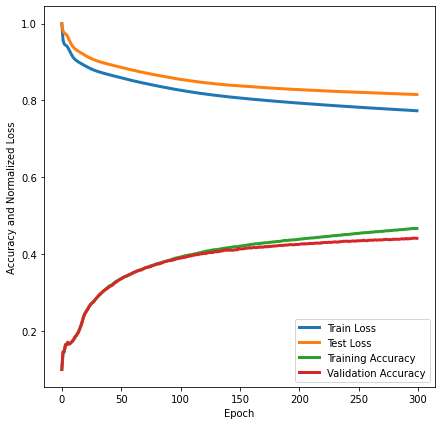

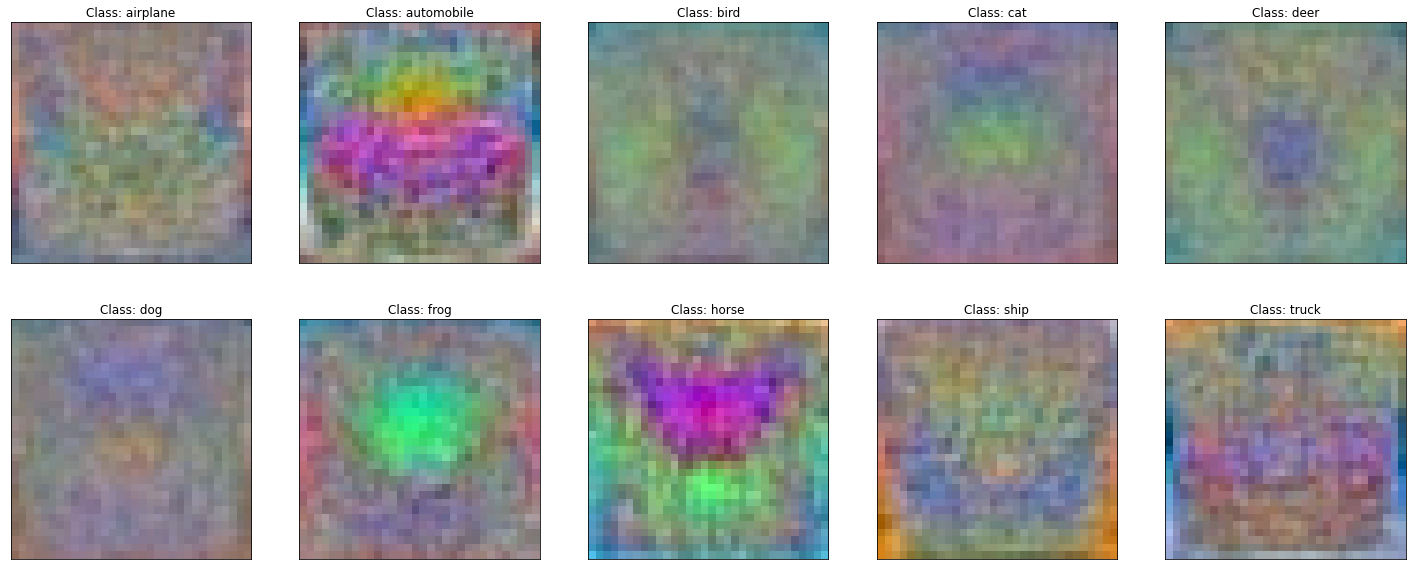

In [36]:
plot(w1,w2,loss_history,test_loss,train_acc_history,val_acc_history)

Part 3

In [15]:
# Loading the Data Set
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)

K = len(np.unique(y_train)) # Number of Classes

Ntr = x_train.shape[0]; print('Number of training samples:', Ntr) # Number of training samples 50,000
Nte = x_test.shape[0]; print('Number of test samples: ',Nte,'\n')      # Number of test samples 10,000
Din = 3072 # CIFAR10 # 32x32x3 = height x width x channel

#x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0) # axis=0: mean of a column; Mean of each pixel
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K); print('y_train: ', y_train.shape); #print(y_train[0:10,:])
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K); #print(y_test[0:10,:])

x_train = np.reshape(x_train,(Ntr,Din)).astype('float32');# print(x_train[0:10, 0:20])
x_test = np.reshape(x_test,(Nte,Din)).astype('float32')
print('x_train: ', x_train.shape)
print('x_test: ', x_test.shape)

x_train:  (50000, 32, 32, 3)
y_train:  (50000, 1)
Pre-processing loaded data...

Number of training samples: 50000
Number of test samples:  10000 

y_train:  (50000, 10)
Reshaped x_train:  (50000, 3072)
Reshaped x_test:  (10000, 3072)
Pre-processing completed.


In [16]:
H = 200 # No of hidden nodes
print("Initializing the weight matrix with random weights...")
std=1e-5 # For random samples from N(\mu, \sigma^2), use: sigma * np.random.randn(...) + mu

# Hidden Layer 
w1 = std*np.random.randn(Din, H) # Initializing the weight matrix with random weights
b1 = np.zeros(H) # Initializing the bias vector
print("w1:", w1.shape)
print("b1:", b1.shape)

# Last Layer
w2 = std*np.random.randn(H, K) # Initializing the weight matrix with random weights
b2 = np.zeros(K) # Initializing the bias vector
print("w2:", w2.shape);print("b2:", b2.shape)

print("Rearranging train and test samples...")
# Rearranging train and test samples: (ra=rearranged)
x_train_ra = np.concatenate((np.ones((x_train.shape[0],1)),x_train), axis=1); print('Rearranged x_train: ', x_train_ra.shape)
x_test_ra  = np.concatenate((np.ones((x_test.shape[0],1)),x_test), axis=1)

# Rearranging weight matrices and bias vectors into single matrices
w1 = np.concatenate((b1.reshape(1,H), w1), axis=0); print('w1: ',w1.shape)
w2 = np.concatenate((b2.reshape(1,K), w2), axis=0); print('w2: ',w2.shape)

print("Rearranging completed.")

iterations = 300  # Gradient descent interations
lr = 1.4e-2 # Learninig rate
lr_decay= 0.999
reg = 5e-6
test_loss = []
loss_history = [] # Vlaues of cost function at each iteration 
train_acc_history = []
val_acc_history = []
mini_batch_loss = []

m = x_train.shape[0]  # Number of training examples
m2 = x_test.shape[0]
# Running gradient descent number of times speciied in iterations
print("Running stochastic gradient descent...")

beginat = time.time()

batch_size = 500 
seed = 0
rng = np.random.default_rng(seed=seed)
for t in range(1,iterations+1):
    indices = np.arange(Ntr)
    rng.shuffle(indices)
    x_train_3 = x_train_ra[indices]
    y_train_3 = y_train[indices]
    
    batch_loss = 0
    for start in range(0,Ntr,batch_size):
        stop = start + batch_size
        # Forward Propagation
        hypo = sigmoid(x_train_3[start:stop].dot(w1)) # Layer 1 with sigmoid activation
        hypothesis = np.concatenate((np.ones((hypo.shape[0],1)),hypo), axis=1) # Rearranging for layer 2
        predict = hypothesis.dot(w2) # Layer 2 

        minibatch_loss = (1/(2*m))*np.sum(( predict - y_train_3[start:stop])**2)\
             + (1/(2*m))*reg*np.sum(w1**2) + (1/(2*m))*reg*np.sum(w2**2)
        
        mini_batch_loss.append(minibatch_loss)
        batch_loss+= minibatch_loss

        # Back Propagation partial dertivatives of Loss function
        # (dl/dw2) = (dl/dpredict)(dpredic/dw2)
        dpredict =  (1/m)*(predict - y_train_3[start:stop])
        dw2 = hypothesis.T.dot(dpredict) + (1/m)*reg*w2

        # (dl/dw1) = (dl/dh)(dh/dw1)
        # (dl/dw1) = (dl/dpredict)(dpredic/dh) * (dh/dw1x)(dw1x/dw1)
        dh = dpredict.dot(w2[1:,].T) # Removing bias vector w2(201x10)--> 200x10
        dhdxw1 = hypo*(1 - hypo) #using hypothesis 50000*200 before rearranging.
        dw1 = x_train_3[start:stop].T.dot(dh*dhdxw1) + (1/m)*reg*w1

        # Gradient Descent
        w1 = w1 - lr*dw1
        w2 = w2 - lr*dw2
    
    loss_history.append(batch_loss)
    
    # Training Accuracy
    hypo = sigmoid(x_train_3.dot(w1)) # Layer 1 with sigmoid activation
    hypothesis = np.concatenate((np.ones((hypo.shape[0],1)),hypo), axis=1) # Rearranging for layer 2
    predict = hypothesis.dot(w2) # Layer 2 
    train_acc = getAccuracy(predict, y_train_3)
    train_acc_history.append(train_acc)
    
    # Validation Accuracy
    test_hypo = sigmoid(x_test_ra.dot(w1))
    test_hypothesis = np.concatenate((np.ones((test_hypo.shape[0],1)),test_hypo), axis=1)# Rearranging for layer 2
    test_predict = test_hypothesis.dot(w2)
    valid_acc = getAccuracy(test_predict, y_test)
    val_acc_history.append(valid_acc)
    
    # Test Loss    
    t_loss = (1/(2*m2))*np.sum(( test_predict- y_test)**2)\
         + (1/(2*m2))*reg*np.sum(w1**2) + (1/(2*m2))*reg*np.sum(w2**2)
    test_loss.append(t_loss)
    
    # Print details for selected iterations
    if (t%30==0) or (t==1):
        print("| Epoch {:03} | Loss {:.4f} | accuracy: {:.4f} | val_loss: {:.4f} | val_accuracy: {:.4f} |"\
             .format(t, batch_loss, train_acc, t_loss, valid_acc))
    #loss: 1.8916 - accuracy: 0.2991 - val_loss: 1.2849 - val_accuracy: 0.5374
    # Decaying learning rate
 
    lr = lr*lr_decay

endat = time.time()    
duration = endat - beginat
print("Stochastic Gradient Descent completed in {} minutes {:.2f} seconds.Parameters were trained."\
      .format(duration//60, duration%60))

Initializing the weight matrix with random weights...
w1: (3072, 200)
b1: (200,)
w2: (200, 10)
b2: (10,)
Rearranging train and test samples...
Rearranged x_train:  (50000, 3073)
Rearranged w1:  (3073, 200)
Rearranged w2:  (201, 10)
Rearranging completed.
Running stochastic gradient descent...
| Epoch 001 | Loss 0.4768 | accuracy: 0.0999 | val_loss: 0.4619 | val_accuracy: 0.0996 |
| Epoch 030 | Loss 0.4180 | accuracy: 0.2849 | val_loss: 0.4174 | val_accuracy: 0.2848 |
| Epoch 060 | Loss 0.4062 | accuracy: 0.3498 | val_loss: 0.4061 | val_accuracy: 0.3493 |
| Epoch 090 | Loss 0.3969 | accuracy: 0.3826 | val_loss: 0.3974 | val_accuracy: 0.3824 |
| Epoch 120 | Loss 0.3897 | accuracy: 0.4056 | val_loss: 0.3911 | val_accuracy: 0.4013 |
| Epoch 150 | Loss 0.3845 | accuracy: 0.4203 | val_loss: 0.3870 | val_accuracy: 0.4149 |
| Epoch 180 | Loss 0.3805 | accuracy: 0.4318 | val_loss: 0.3841 | val_accuracy: 0.4208 |
| Epoch 210 | Loss 0.3770 | accuracy: 0.4419 | val_loss: 0.3818 | val_accuracy: 0.4

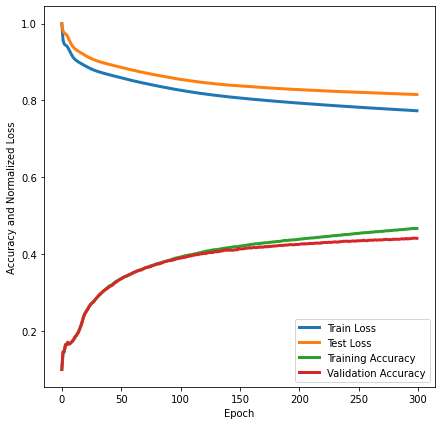

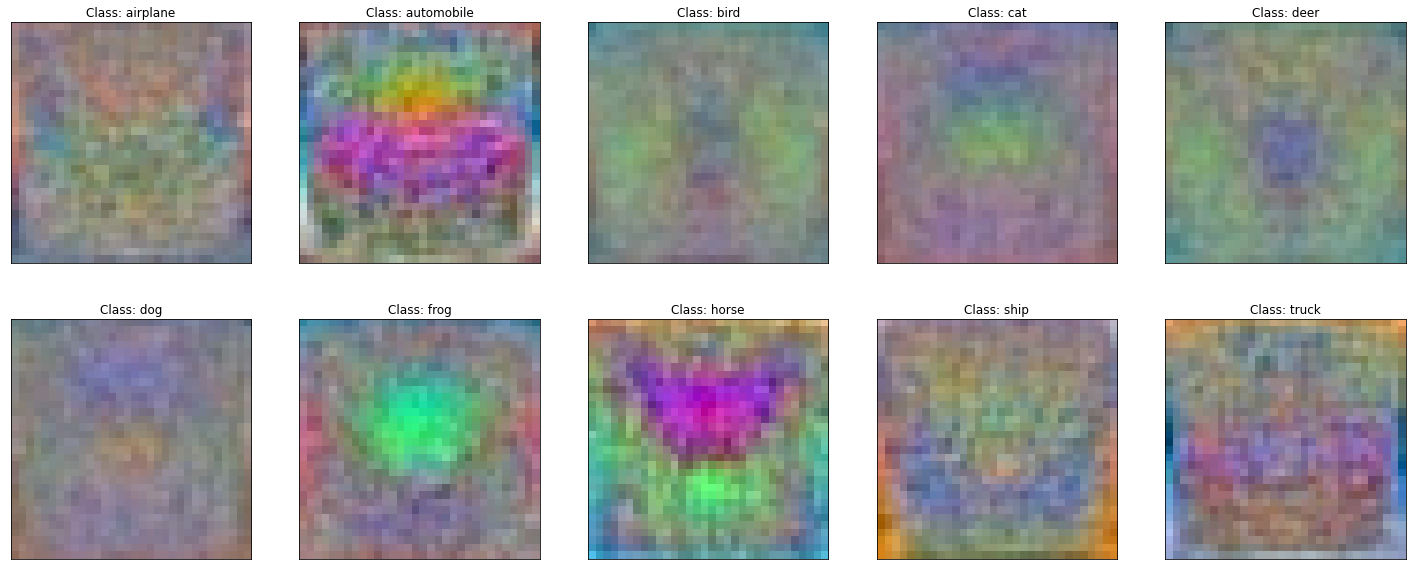

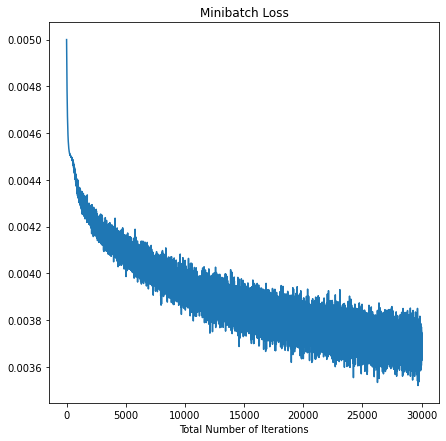

In [37]:
plot(w1,w2,loss_history,test_loss,train_acc_history,val_acc_history)
plt.figure(figsize=(7,7))
plt.plot(mini_batch_loss); plt.title('Minibatch Loss')
plt.xlabel("Total Number of Iterations");

In [20]:
%matplotlib inline
%load_ext tensorboard
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets,layers, models

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()       #load data

K = len(np.unique(y_train))     # Number of classes
# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Create a sequential model
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(32,32,3)))        # 32, 3X3 convolution layers
model.add(layers.MaxPooling2D((2,2)))                                               # 2x2 max pooling layer
model.add(layers.Conv2D(64,(3,3), activation='relu' ))                              # 64, 3X3 convolution layers
model.add(layers.MaxPooling2D((2,2)))                                               # 2x2 max pooling layer
model.add(layers.Conv2D(64,(3,3), activation='relu' ))                              # 64, 3X3 convolution layers
model.add(layers.MaxPooling2D((2,2)))                                               # 2x2 max pooling layer
model.add(layers.Flatten())                                                         # Flattening the output of the convolutional layer
model.add(layers.Dense(64, activation='relu' ))                                     # fully connected layer with 64 units
model.add(layers.Dense(10))                                                         # fully connected layer with 10 units

model.summary()     #Get model summary
SGD=tf.keras.optimizers.SGD(learning_rate=0.01, decay=0.999, momentum =0.9, name='SGD', nesterov= False) #Get SGD optimizer with momentum
model.compile(optimizer=SGD, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy']) 

history = model.fit(x_train, y_train, epochs=50, batch_size=50, validation_data=(x_test, y_test))

print(model.optimizer.get_config())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

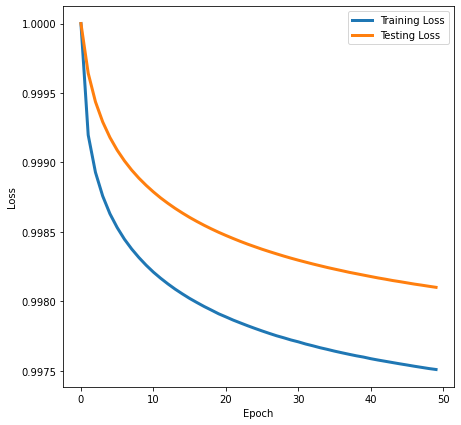

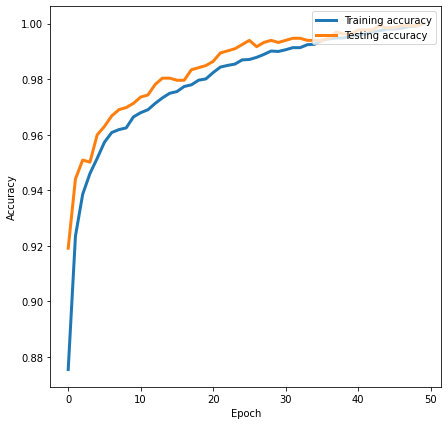

In [31]:


plt.figure(figsize=(7,7))
plt.plot(history.history['loss']/np.max(history.history['loss']), linewidth=3, label = 'Training Loss')
plt.plot(history.history['val_loss']/np.max(history.history['val_loss']), linewidth=3, label = 'Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.figure(figsize=(7,7))
plt.plot(history.history['accuracy']/np.max(history.history['accuracy']), linewidth=3, label = 'Training accuracy')
plt.plot(history.history['val_accuracy']/np.max(history.history['val_accuracy']), linewidth=3, label = 'Testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.show()